### Our objective:
- Given a query artist name, find similar artists through analysis of User data (Item Based Collaborative Filtering) 
- Given a list of favourite artists (in Red), plot a **Recommendation Graph** to visualize similar artists (in Blue).
    
<img style="float:left;" src="images/red hot chili peppers-k10-test_pred.png" width=600 height=300 align='center'>
<img style="float:right;" src="images/graph-my-30.png.png" width=600 height=600>
<img style="float:left;" src="images/the doors-k20-test2.png" width=600 height=300 align='center'>

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import os.path as osp
import matplotlib.pyplot as plt
pd.set_option('display.float_format', lambda x: '%0.3f'%x)

In [2]:
dataset_path = '/home/abhirup/Downloads/Datasets/lastfm-dataset-360K/'
users_table = '/home/abhirup/Downloads/Datasets/lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv'
profiles_table = '/home/abhirup/Downloads/Datasets/lastfm-dataset-360K/usersha1-profile.tsv'

## Preparing datasets

In [3]:
data_user = pd.read_table(users_table, header=None, nrows=2e7, 
                         names = ['users', 'artist-id', 'artist-name', 'plays'],
                         usecols = ['users', 'artist-name', 'plays'])
if data_user['artist-name'].isnull().sum() > 0: #if there are records with no artist-name
    data_user = data_user.dropna(axis=0, subset=['artist-name'])
## Shuffle the user data
data_user = data_user.sample(frac=1).reset_index(drop=True)

In [4]:
data_profiles = pd.read_table(profiles_table, header=None, 
                             names = ['users', 'gender', 'age', 'country', 'signup'],
                             usecols = ['users', 'gender', 'age', 'country'])

In [5]:
len(data_user), len(data_profiles)

(17535451, 359347)

## Filtering artists by *popularity*

In [6]:
##finding total plays per artist
artist_plays = data_user.groupby(by=['artist-name'])['plays'].sum()
artist_plays = artist_plays.reset_index()
artist_plays.rename(columns = {'plays': 'total_plays'}, inplace=True) 

In [7]:
artist_plays.head()

,artist-name,total_plays
0,04)],6
1,2,1606
2,58725ab=>,23
3,80lİ yillarin tÜrkÇe sÖzlÜ aŞk Şarkilari,70
4,amy winehouse,23


In [8]:
##merging with original user database 
user_merge_artist = data_user.merge(artist_plays, left_on="artist-name", right_on="artist-name", 
                                   how = 'left')

In [9]:
user_merge_artist.head()

,users,artist-name,plays,total_plays
0,503ecba15c5fb367276733848581e1828fc12488,the clash,13,4604089
1,4a2b5b3ba2cc735604a91d0b62a4a4c5034f3e3e,isan,249,204966
2,245a2b6d0a98e61b34a96d6a756eae960521c8c3,the pussycat dolls,671,1306764
3,3a29f0211911519f0c0dcfdefb1e619a8c47d874,fireworks,28,75040
4,7dea1fa19beab3f4d0e2f8ff15796582472ca3a7,judas priest,1333,3073639


In [10]:
##picking a threshold for Popularity
print("Total Play Stats")
print(artist_plays.describe())
print("\nUpper Quantile Stats")
print(artist_plays.quantile(np.arange(0.8, 1, 0.01)))

Total Play Stats
       total_plays
count   292363.000
mean     12907.022
std     185981.631
min          1.000
25%         53.000
50%        208.000
75%       1048.000
max   30466827.000

Upper Quantile Stats
       total_plays
0.800     1651.000
0.810     1832.000
0.820     2033.000
0.830     2277.000
0.840     2561.000
0.850     2909.000
0.860     3315.000
0.870     3795.000
0.880     4420.000
0.890     5169.180
0.900     6137.800
0.910     7409.420
0.920     9102.040
0.930    11474.660
0.940    14898.000
0.950    19964.500
0.960    28420.120
0.970    43541.420
0.980    79403.560
0.990   198483.660


### *Conclusions*:
- 1% artists have ~2,00,000 or more plays
- 2% artists have ~80,000 or more plays
- 3% artists have ~43,000 or more plays
- 5% artists have ~20,000 or more plays 

### Our limiting popularity threshold is **40000** (~3% artists)

In [11]:
popl_threshold = 40000 ##40000 for data_user length of 2e7
user_popl_artist = user_merge_artist.query('total_plays >= @popl_threshold')

## Filtering users by *country*

In [12]:
country = 'United States'
users_US = (user_popl_artist.merge(data_profiles, left_on='users', right_on='users', how='left')
            .query('country == @country'))

In [13]:
users_US.head()

,users,artist-name,plays,total_plays,gender,age,country
3,3a29f0211911519f0c0dcfdefb1e619a8c47d874,fireworks,28,75040,m,nan,United States
15,afe27109ccf05eebf946784dc1a4856304f1f645,marnie stern,26,73243,m,nan,United States
16,9a7ed4dd03b444194fa59e4ac235c698c7eeee6f,battles,180,534194,m,21.000,United States
17,b0f01ae2adf24b163d0e2f034b3dd33d0468b34f,the undertones,41,129943,m,36.000,United States
21,5557874ada6e7e8fd436dc173e80f71c70dadcdd,avril lavigne,7,4584028,NaN,nan,United States


In [15]:
country = 'India'
users_IN = (user_popl_artist.merge(data_profiles, left_on='users', right_on='users', how='left')
            .query('country == @country'))

In [16]:
users_IN.head()

,users,artist-name,plays,total_plays,gender,age,country
323,02c54f0a691c93bb78632c3ec61c693c3867490c,the beatles,284,382809,m,18.000,India
435,01495b2100da53802382b726df7b5e8759913901,zero 7,25,12727,NaN,34.000,India
1114,018b9e49d20e522b4e169ea8fc587cc418e946c3,guns n' roses,98,23158,m,22.000,India
1441,018b9e49d20e522b4e169ea8fc587cc418e946c3,the who,642,37148,m,22.000,India
1911,02c54f0a691c93bb78632c3ec61c693c3867490c,r.e.m.,51,63713,m,18.000,India


In [14]:
## Removing duplicates
if not users_US.duplicated(['users', 'artist-name']).empty:
    print('Initial USER-ARTIST-^USA^ size {0}'.format(users_US.shape))
    users_US.drop_duplicates(['users', 'artist-name'], inplace=True)
    print('Final USER-ARTIST-^USA^ size {0}'.format(users_US.shape))

Initial USER-ARTIST-^USA^ size (2788019, 7)
Final USER-ARTIST-^USA^ size (2788013, 7)


## Implementing a Nearest-Neighbor model

In [ ]:
## Reshaping in matrix format
user_artist_matrix = users_US.pivot(index='artist-name', columns='users', values='plays').fillna(0)
user_artist_matrix_sparse = csr_matrix(user_artist_matrix)

In [25]:
user_artist_matrix.index

Index(['...and you will know us by the trail of dead', '2pac', '3 doors down',
       '30 seconds to mars', '311', '50 cent', '65daysofstatic', ':wumpscut:',
       '[unknown]', 'a day to remember',
       ...
       'zero 7', 'くるり', 'ムック', '増田俊郎', '宇多田ヒカル', '梶浦由記', '植松伸夫', '浜崎あゆみ',
       '菅野よう子', '동방신기'],
      dtype='object', name='artist-name', length=976)

In [27]:
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric='cosine', algorithm = 'brute', n_neighbors=10, n_jobs=8)
model_knn.fit(user_artist_matrix_sparse)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=8, n_neighbors=10, p=2, radius=1.0)

## Making recommendations

In [30]:
query_index = np.random.choice(user_artist_matrix.shape[0])
user_artist_matrix.iloc[query_index,:].describe()

count    756.000
mean      16.258
std      111.562
min        0.000
25%        0.000
50%        0.000
75%        0.000
max     1790.000
Name: explosions in the sky, dtype: float64

In [36]:
distances, indices = model_knn.kneighbors(user_artist_matrix.iloc[query_index,:]
                                          .values.reshape(1,-1))
for i in range(0, len(distances.flatten())):
    if i == 0:
        print ('Recommendations for {0}:\n'.format(user_artist_matrix.index[query_index]))
    else:
        print ('{0}: {1}, with distance of {2}:'
               .format(i, user_artist_matrix.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for explosions in the sky:

1: josé gonzález, with distance of 0.4198580535134766:
2: why?, with distance of 0.431568224230817:
3: santogold, with distance of 0.4342610850351739:
4: ben folds, with distance of 0.4400900903787045:
5: incubus, with distance of 0.46007890487646963:
6: the album leaf, with distance of 0.46399813849800264:
7: mika, with distance of 0.46995668926730483:
8: ben folds five, with distance of 0.4798721312178853:
9: dr. dre, with distance of 0.4806861825129535:


In [42]:
out = model_knn.kneighbors_graph(
#     user_artist_matrix.iloc[query_index,:].values.reshape(1,-1), 
                                mode='distance')

In [46]:
print(out[query_index])

  (0, 445)	0.4198580535134766
  (0, 955)	0.431568224230817
  (0, 710)	0.4342610850351739
  (0, 103)	0.4400900903787045
  (0, 405)	0.46007890487646963
  (0, 805)	0.46399813849800264
  (0, 555)	0.46995668926730483
  (0, 104)	0.4798721312178853
  (0, 268)	0.4806861825129535
  (0, 765)	0.4837444149749307


## **Fuzzy Matching**

In [328]:
import string
from fuzzywuzzy import fuzz
def get_artist_recommendations(query_artist, artist_plays_matrix, model_knn, k, printOption=True):
    """
    Inputs:
    query_artist: query artist name
    artist_plays_matrix: artist play count dataframe (not the sparse one, the pandas dataframe)
    knn_model: our previously fitted sklearn knn model
    k: the number of nearest neighbors.
    
    Prints: Artist recommendations for the query artist
    Returns: None
    """
    query_index = None
    ratio_tuples = []
    
    for i in artist_plays_matrix.index:
        ratio = fuzz.ratio(i.lower(), query_artist.lower())
        if ratio >= 75:
            current_query_index = artist_plays_matrix.index.tolist().index(i)
            ratio_tuples.append((i, ratio, current_query_index))
    
#     if printOption: print('Possible matches: {0}\n'.format([(x[0], x[1]) for x in ratio_tuples]))
    
    try:
        query_index = max(ratio_tuples, key = lambda x: x[1])[2] # get the index of the best artist match in the data
    except:
        print('Your artist didn\'t match any artists in the data. Try again')
        return None
    
    distances, indices = model_knn.kneighbors(artist_plays_matrix.iloc[query_index, :]
                                              .values.reshape(1, -1), 
                                              n_neighbors = k + 1)
    
    recomms = {'MyID':{
                    'name': artist_plays_matrix.index[query_index],
                    'index': query_index
                      }}
    for i in range(0, len(distances.flatten())):
        if i == 0:
            if printOption: print('Recommendations for {0} @index {1}'.format(artist_plays_matrix.index[query_index], query_index))
        else:
            recomms[user_artist_matrix.index[indices.flatten()[i]]] = distances.flatten()[i]
    if printOption:
        for i, r in enumerate(recomms):
            if r is 'MyID': continue
            print('{0}: {1}, with distance of {2}:'.format(i, r, recomms[r]))
    return recomms

In [329]:
recomms = get_artist_recommendations('red hot chili peppers', user_artist_matrix, model_knn, k = 10);

Recommendations for red hot chili peppers @index 688
1: sublime, with distance of 0.41152928213161:
2: the doors, with distance of 0.41511009870640736:
3: mad caddies, with distance of 0.4482110745891701:
4: imogen heap, with distance of 0.4973271416398075:
5: jimi hendrix, with distance of 0.4992572743065221:
6: jefferson airplane, with distance of 0.5157176067266546:
7: damien rice, with distance of 0.5174349929870679:
8: jack johnson, with distance of 0.55248784519443:
9: lupe fiasco, with distance of 0.5534124773928357:
10: nirvana, with distance of 0.5700037458189458:


## **Recommendation Cloud**

In [367]:
from wordcloud import WordCloud
def get_recom_cloud(query_artist, artist_plays_matrix = user_artist_matrix, model_knn = model_knn, k=20, saveSuffix = None):
    recomms = get_artist_recommendations(query_artist, artist_plays_matrix, model_knn, k = k, printOption=False)
    artist_id = recomms.pop('MyID', None)
#     print(artist_id)
    for r in recomms:
        recomms[r] = 4 / recomms[r] ## quantifying 
    wc = WordCloud(width=1000, height=500, max_words=50, background_color='black', prefer_horizontal=0.9, min_font_size=20, max_font_size=160)
    im = wc.generate_from_frequencies(recomms)
#     %matplotlib inline
    plt.figure(figsize=(20, 40)), plt.imshow(im), plt.tight_layout(), plt.axis('off')
    plt.show()
    if saveSuffix is not None:
        if artist_id is None: 
            print("Can't save. Artist 'MyID' missing")
            pass
        plt.imsave('{0}-k{1}-{2}.png'.format(artist_id['name'], k, saveSuffix), im)

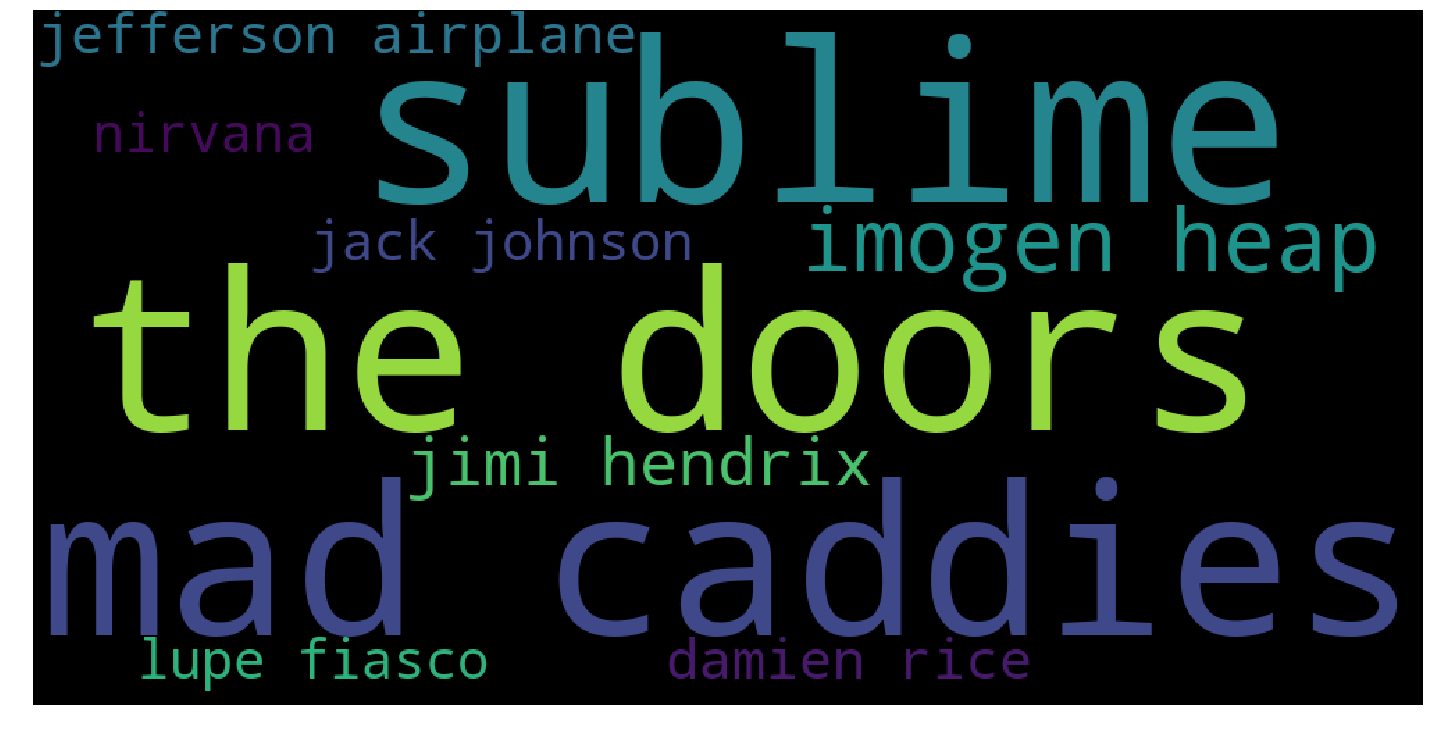

In [368]:
get_recom_cloud('red hot chili peppers', user_artist_matrix, model_knn, k = 10, saveSuffix='test_pred')

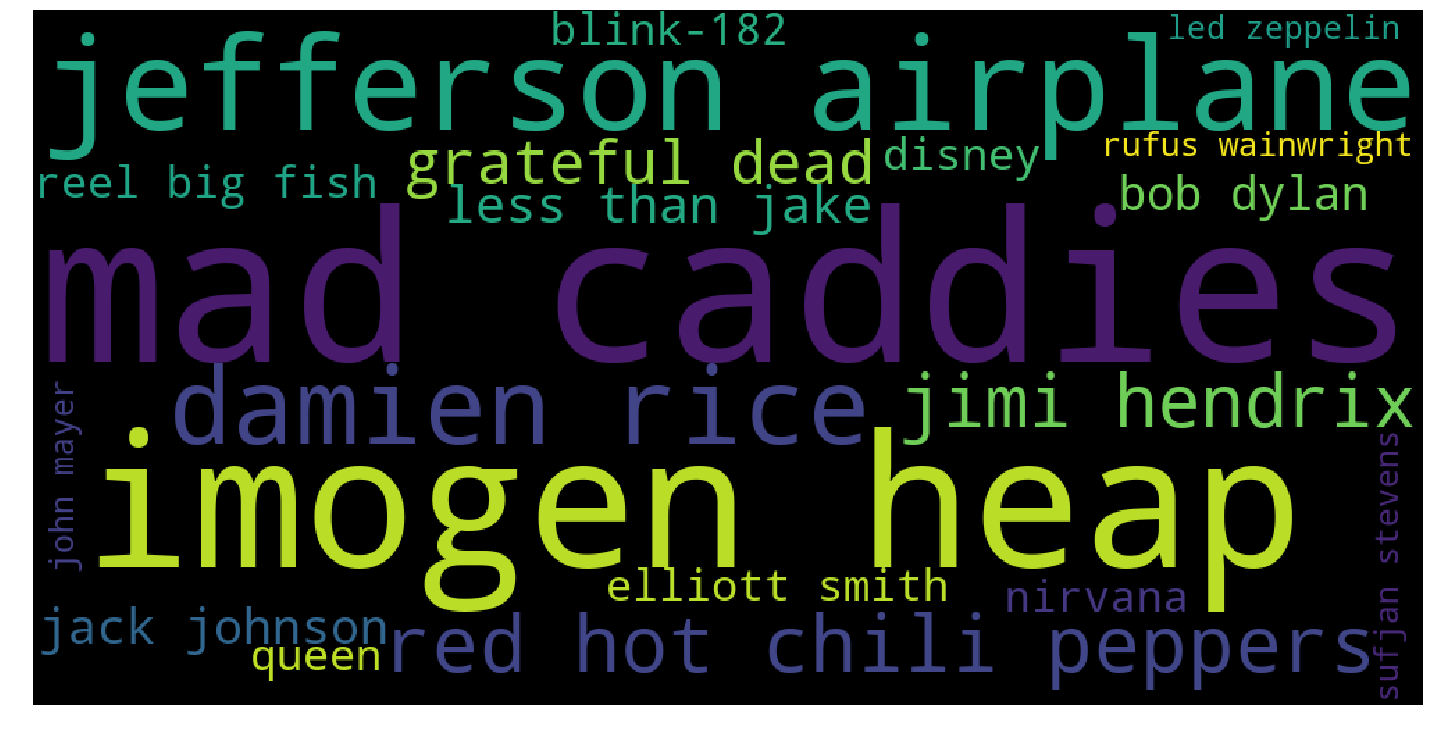

In [369]:
get_recom_cloud('the doors', user_artist_matrix, model_knn, k=20, saveSuffix='test2')

## **Recommendation Graph**

In [216]:
import networkx as nx

In [1]:
def get_recomm_graph(my_coll, artist_plays_matrix = user_artist_matrix, model_knn = model_knn, k=20, saveSuffix = None):
    recomm_coll = {}
    for i in my_coll:
        recomm_coll[i] = get_artist_recommendations(i, user_artist_matrix, model_knn, k, printOption=False)
        recomm_coll[i].pop('MyID')
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    G = nx.Graph()
    for i in recomm_coll:
        G.add_node(i, )
        for j in recomm_coll[i]:
            G.add_node(j)
            G.add_edge(i, j, length = 4 / recomm_coll[i][j])        
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color='green', node_size=250, alpha=0)
    for label in my_coll:
        x, y = pos[label]
        plt.text(x, y, s=label, horizontalalignment = 'center', verticalalignment='center', fontsize=12, fontweight='semibold', wrap=True, bbox=dict(facecolor='red', alpha=0.2))
    for i in recomm_coll:
        for j in recomm_coll[i]:
            if j not in my_coll:
                x, y = pos[j]
                plt.text(x, y, s=j, horizontalalignment = 'center', verticalalignment='center', color='white', fontsize=12, fontweight='semibold', wrap=True, bbox=dict(facecolor='blue', alpha=0.5))
    plt.tight_layout()
    fig.set_facecolor("#00000F")
    plt.axis('off')
    if saveSuffix is not None:
        fig.savefig('{0}.png'.format(saveSuffix))

NameError: name 'user_artist_matrix' is not defined

In [364]:
my_coll = ['red hot chili peppers', 'the doors', 'mad caddies']

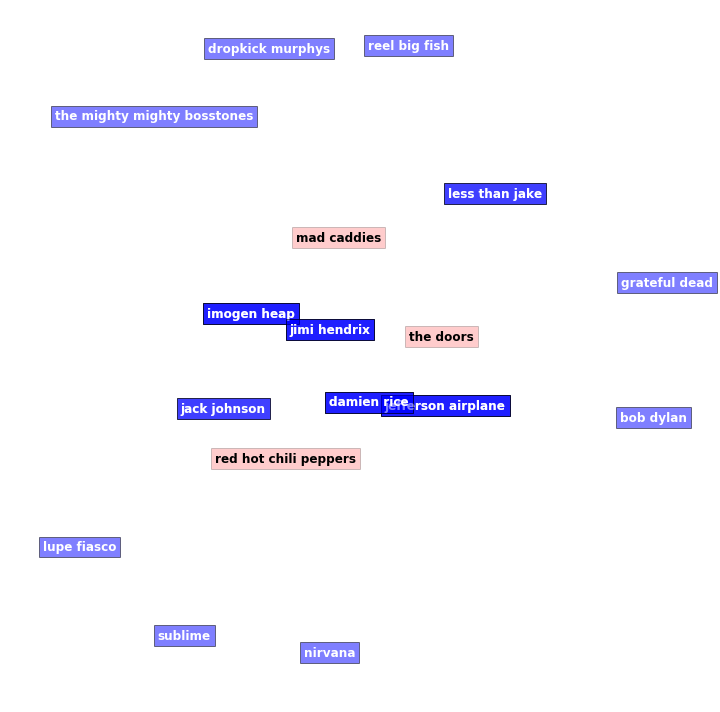

In [380]:
get_recomm_graph(my_coll, user_artist_matrix, model_knn, k=10, saveSuffix='graph-my.png')

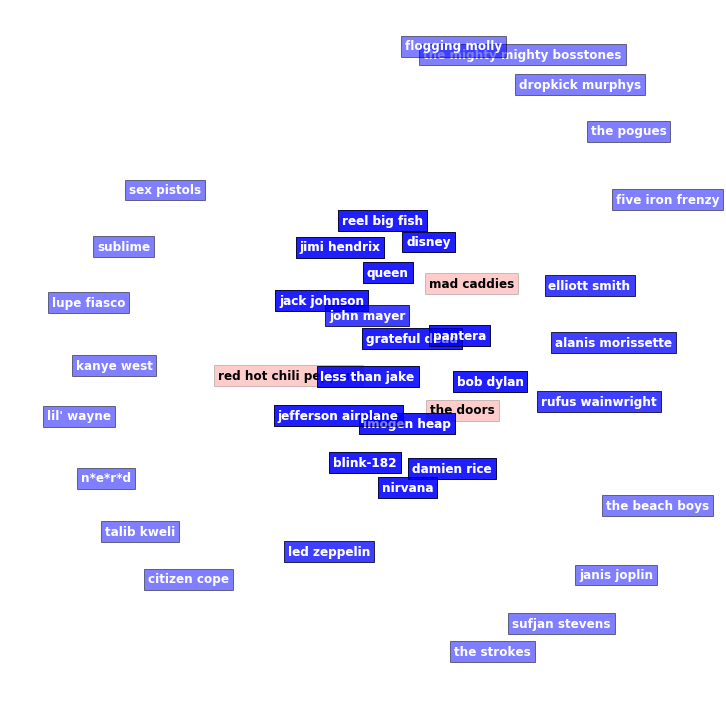

In [381]:
get_recomm_graph(my_coll, user_artist_matrix, model_knn, k=25, saveSuffix='graph-my-30.png')